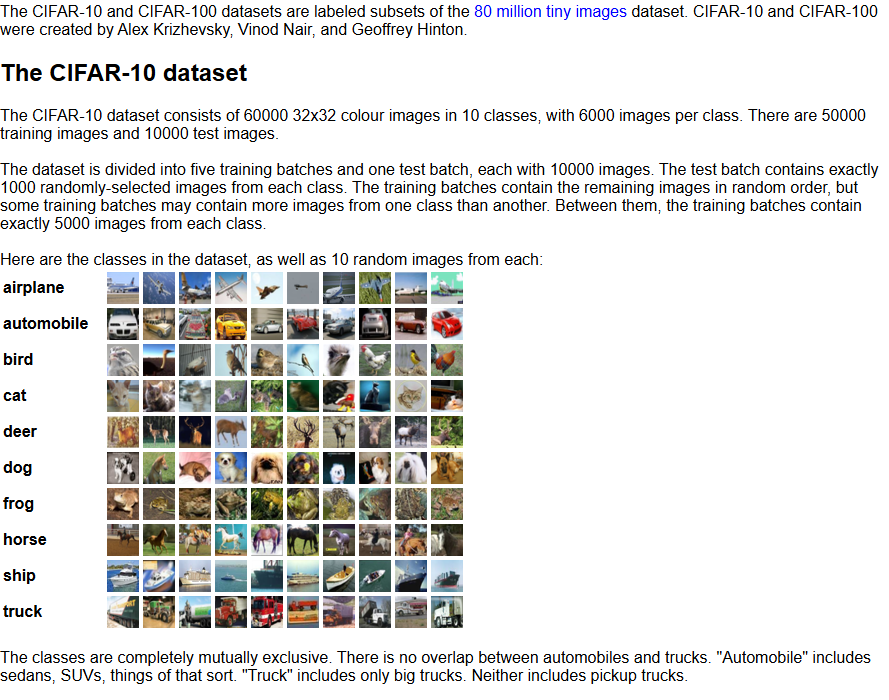

## VGG16 from Scratch

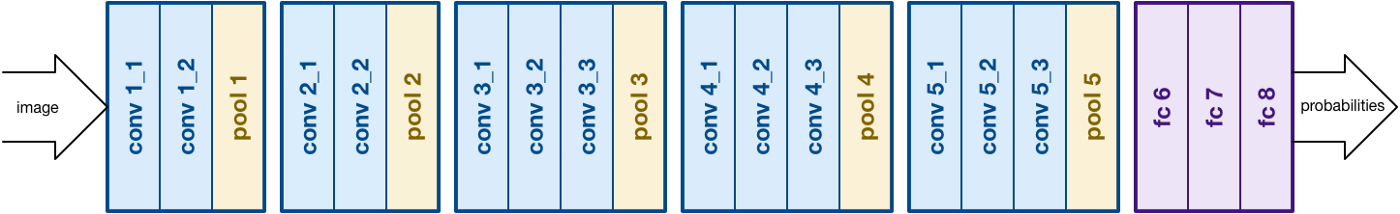

Using device: cuda


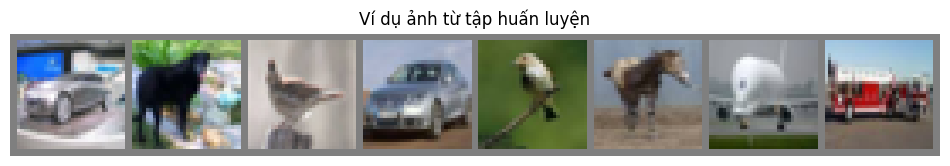

Epoch [1/5] Train Loss: 1.3252


Epoch [2/5] Train Loss: 0.8229


Epoch [3/5] Train Loss: 0.6181


Epoch [4/5] Train Loss: 0.4914


Epoch [5/5] Train Loss: 0.3941
Test Accuracy: 79.95%


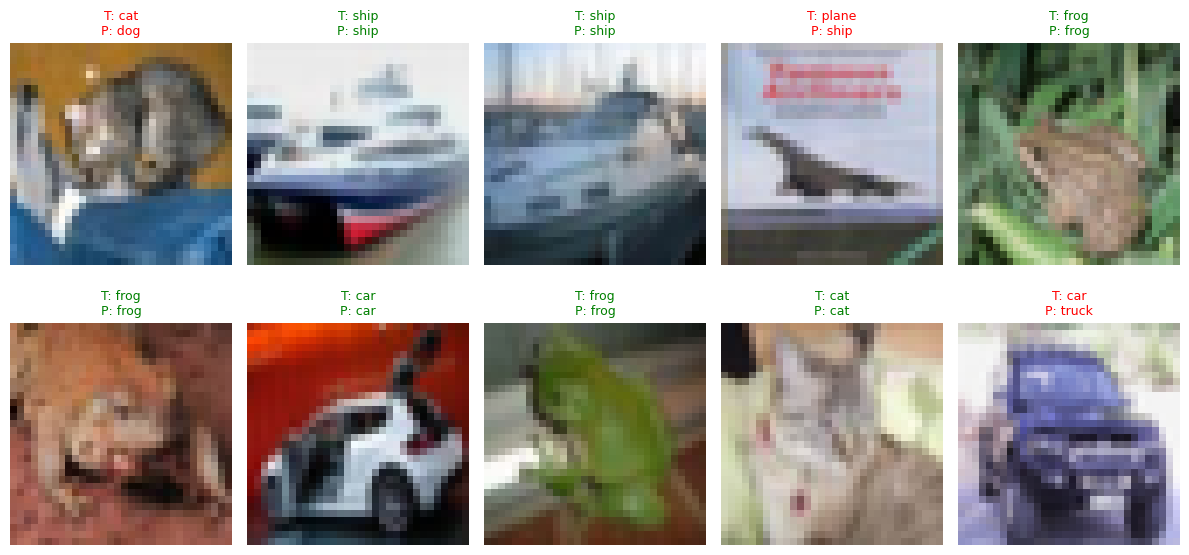

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

# =========================================================
# 1️/ Cấu hình thiết bị (CPU hoặc GPU)
# =========================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# =========================================================
# 2️/ Chuẩn bị dữ liệu CIFAR-10
# =========================================================
"""
CIFAR-10 gồm 10 lớp ảnh màu (32x32 pixel): máy bay, ô tô, chim, mèo, hươu, chó, ếch, ngựa, tàu, xe tải.
Tổng cộng 60.000 ảnh: 50.000 ảnh train, 10.000 ảnh test.
"""

# Chuẩn hóa dữ liệu:
# - Đưa giá trị pixel (0–1) về phân phối có trung bình 0, độ lệch chuẩn 1
# - Giúp mạng học nhanh hơn và ổn định hơn (tránh gradient quá lớn)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Tải dữ liệu train & test gốc
train_set = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
test_set = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False)

classes = ['plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

# =========================================================
# 3️/ Hiển thị vài ảnh mẫu
# =========================================================
def imshow(img):
    img = img / 2 + 0.5  # đảo ngược normalize để hiển thị đúng màu
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(train_loader)
images, labels = next(dataiter)

plt.figure(figsize=(12, 3))
imshow(torchvision.utils.make_grid(images[:8]))
plt.title("Ví dụ ảnh từ tập huấn luyện")
plt.axis("off")
plt.show()

# =========================================================
# 4️/ Mô hình VGG16 rút gọn cho CIFAR10
# =========================================================
"""
Ý tưởng chính:
- VGG16 sử dụng nhiều lớp Conv 3x3 liên tiếp thay vì kernel lớn → giúp học đặc trưng sâu hơn.
- Mỗi khối gồm: Conv → BatchNorm → ReLU → MaxPool
- Cuối cùng là Fully Connected để phân loại 10 lớp.
"""

class VGG16(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16, self).__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Block 2
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Block 3
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Block 4
            nn.Conv2d(256, 512, 3, padding=1), nn.BatchNorm2d(512), nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1), nn.BatchNorm2d(512), nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1), nn.BatchNorm2d(512), nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Block 5
            nn.Conv2d(512, 512, 3, padding=1), nn.BatchNorm2d(512), nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1), nn.BatchNorm2d(512), nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1), nn.BatchNorm2d(512), nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

model = VGG16().to(device)

# =========================================================
# 5️/ Định nghĩa Loss, Optimizer, Scheduler
# =========================================================
"""
- CrossEntropyLoss: dùng cho phân loại nhiều lớp.
- SGD: tối ưu đơn giản, ổn định, hay dùng trong CNN cổ điển.
  + momentum: giúp tránh mắc kẹt trong vùng dốc nhỏ.
  + weight_decay: regularization L2 để giảm overfitting.
- Scheduler: giảm learning rate dần, giúp tinh chỉnh mô hình ở giai đoạn cuối.
"""
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.5)

num_epochs = 5

# =========================================================
# 6️/ Training
# =========================================================
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", leave=False)
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    avg_train_loss = running_loss / len(train_loader)
    scheduler.step()

    print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {avg_train_loss:.4f}")

# =========================================================
# 7/ Đánh giá mô hình trên tập test
# =========================================================
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

# =========================================================
# 8/ Hiển thị kết quả dự đoán trên vài ảnh test
# =========================================================
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, predicted = torch.max(outputs, 1)

plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    imshow(images[i].cpu())
    true_label = classes[labels[i]]
    pred_label = classes[predicted[i]]
    color = "green" if true_label == pred_label else "red"
    plt.title(f"T: {true_label}\nP: {pred_label}", color=color, fontsize=9)
    plt.axis("off")
plt.tight_layout()
plt.show()

## ResNet34 fom Scratch

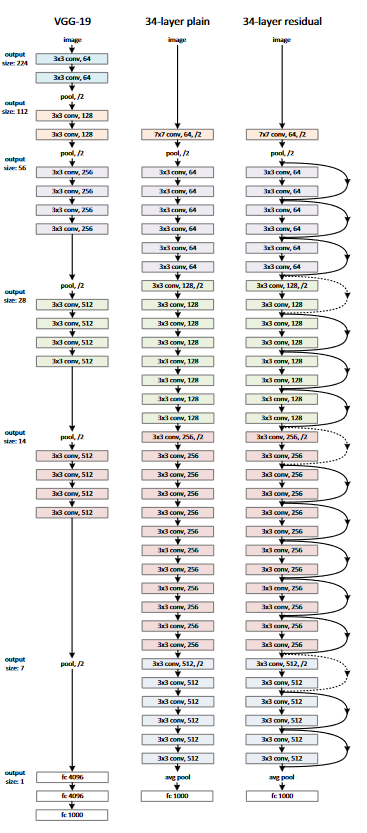

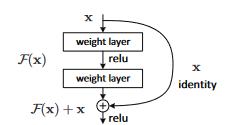

Using device: cuda


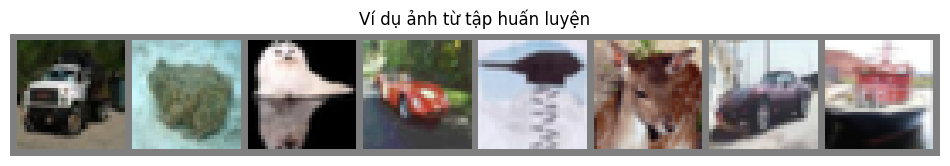

Epoch [1/5]: 100%|██████████| 391/391 [01:19<00:00,  4.89it/s, loss=1.77]


Epoch [1/5] | Train Loss: 2.0952 | Test Acc: 40.73%


Epoch [2/5]: 100%|██████████| 391/391 [01:19<00:00,  4.91it/s, loss=1.4]


Epoch [2/5] | Train Loss: 1.4673 | Test Acc: 50.73%


Epoch [3/5]: 100%|██████████| 391/391 [01:19<00:00,  4.90it/s, loss=0.967]


Epoch [3/5] | Train Loss: 1.1727 | Test Acc: 56.81%


Epoch [4/5]: 100%|██████████| 391/391 [01:19<00:00,  4.90it/s, loss=0.813]


Epoch [4/5] | Train Loss: 0.9450 | Test Acc: 66.96%


Epoch [5/5]: 100%|██████████| 391/391 [01:19<00:00,  4.90it/s, loss=0.87]


Epoch [5/5] | Train Loss: 0.7879 | Test Acc: 70.75%


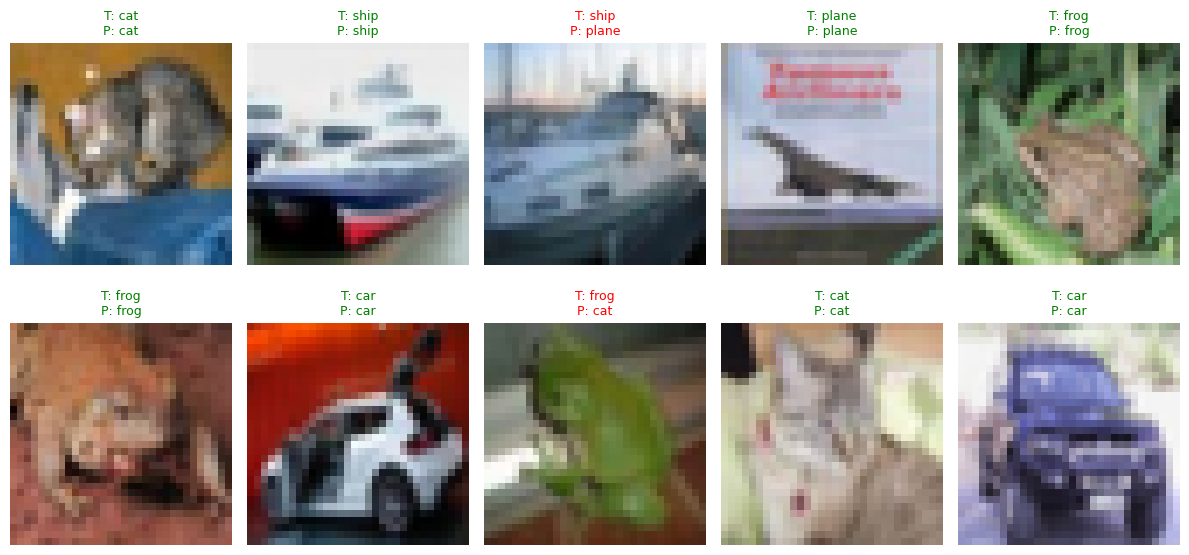

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

# =========================================================
# 1/ Cấu hình thiết bị
# =========================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# =========================================================
# 2️/ Chuẩn bị dữ liệu CIFAR-10
# =========================================================
"""
CIFAR-10 gồm 10 lớp ảnh màu (32x32): máy bay, ô tô, chim, mèo, hươu, chó, ếch, ngựa, tàu, xe tải.
"""

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_set = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
test_set = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False)

classes = ['plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

# =========================================================
# 3️/ Hiển thị vài ảnh mẫu
# =========================================================
def imshow(img):
    img = img / 2 + 0.5  # đảo normalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(train_loader)
images, labels = next(dataiter)
plt.figure(figsize=(12, 3))
imshow(torchvision.utils.make_grid(images[:8]))
plt.title("Ví dụ ảnh từ tập huấn luyện")
plt.axis("off")
plt.show()

# =========================================================
# 4️/ Xây dựng kiến trúc ResNet34 (from scratch)
# =========================================================
"""
ResNet34 gồm 34 lớp (Conv + BN + ReLU + Skip Connection):
- 4 nhóm residual block: [3, 4, 6, 3]
- Mỗi block gồm 2 convolution 3x3 + BatchNorm + ReLU
- Sử dụng skip connection để tránh vanishing gradient
"""

class BasicBlock(nn.Module):
    expansion = 1  # không thay đổi số channel

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out

class ResNet34(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet34, self).__init__()
        self.in_channels = 64

        # CIFAR-10 nhỏ, nên kernel đầu giảm còn 3x3 thay vì 7x7 (như ImageNet)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion)
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion

        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Khởi tạo mô hình
model = ResNet34(BasicBlock, [3, 4, 6, 3], num_classes=10).to(device)

# =========================================================
# 5️/ Loss, Optimizer, Scheduler
# =========================================================
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

# =========================================================
# 6️/ Huấn luyện mô hình
# =========================================================
num_epochs = 5
train_losses, test_accs = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]")

    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    scheduler.step()
    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)

    # --- Đánh giá trên tập test ---
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    test_accs.append(acc)
    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_loss:.4f} | Test Acc: {acc:.2f}%")

# =========================================================
# 7/ Dự đoán thử vài ảnh
# =========================================================
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, predicted = torch.max(outputs, 1)

plt.figure(figsize=(12,6))
for i in range(10):
    plt.subplot(2,5,i+1)
    imshow(images[i].cpu())
    true_label = classes[labels[i]]
    pred_label = classes[predicted[i]]
    color = 'green' if true_label == pred_label else 'red'
    plt.title(f"T: {true_label}\nP: {pred_label}", color=color, fontsize=9)
    plt.axis('off')
plt.tight_layout()
plt.show()